In [1]:
# Load library
import matplotlib.pyplot as plt

import ipywidgets as widgets

import os
from scapy.all import *

In [2]:
# read pcap files
def read_pcap(root_dir, ext=('.pcap', '.pcapng')):
    queue = [root_dir]
    while len(queue) != 0:
        nest_dir = queue.pop()
        with os.scandir(nest_dir) as it:
            for entry in it:
                if not entry.name.startswith('.') and entry.is_file():
                    if entry.name.endswith(ext):
                        label = os.path.basename(os.path.dirname(entry.path)) # dirname is label
                        yield label, entry.path
                elif not entry.name.startswith('.') and entry.is_dir():
                    queue.append(entry.path)

In [3]:
# Metadata analysis
## X-axis: 
## Y-axis: 
data = dict()
datat = dict()
pcap_path = os.path.abspath(os.path.expanduser('./data'))
for label, path in read_pcap(pcap_path):
    rp = rdpcap(path, count=1000)
    d = data.get(label, dict())
    for k, v in rp.sessions().items():
        if 'TCP' not in k: # filter only TCP packets
            continue
        cnt = len(v)
#         if cnt > 5:
#             for pkt in v:
#                 print(cnt, pkt.__repr__())
        d[cnt] = d.get(cnt, 0) + 1
        datat[cnt] = datat.get(cnt, 0) + 1
    data[label] = d

<IPython.core.display.Javascript object>


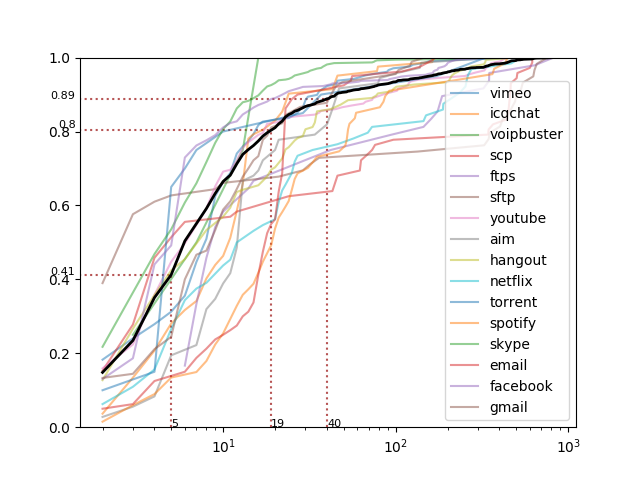

In [4]:
%matplotlib notebook

labels = list()
for key in data.keys():
    labels.append(key)
    dptr = data[key]
    d = list(dptr.items())
    d.sort()
    x = list()
    y = list()
    t = sum([v for k, v in d if k != 1])
    s = 0
    for k, v in d:
        if k == 1:
            continue
        x.append(k)
        s = s + v
        y.append(s/t)
    fig = plt.plot(x, y, alpha=0.5)
d2 = list(datat.items())
d2.sort()
x = list()
y = list()
t = sum([v for k, v in d2 if k != 1])
s = 0
for k, v in d2:
    if k == 1:
        continue
    x.append(k)
    s = s + v
    y.append(s/t)
plt.plot(x, y, color='black', linewidth=2)

plt.vlines(5, 0, y[x.index(5)], color='brown', linestyles='dotted', alpha=0.8)
plt.hlines(y[x.index(5)], 0, 5, color='brown', linestyles='dotted', alpha=0.8)
plt.text(5, 0, round(5,2), fontsize=8)
plt.text(1, y[x.index(5)], round(y[x.index(5)],2), fontsize=8)

for i in y:
    if i >= 0.8:
        y08 = y.index(i)
        x08 = x[y08]
        break

plt.vlines(x08, 0, y[y08], color='brown', linestyles='dotted', alpha=0.8)
plt.hlines(y[y08], 0, x08, color='brown', linestyles='dotted', alpha=0.8)
plt.text(x08, 0, round(x08,2), fontsize=8)
plt.text(1+0.1, y[y08]+0.005, round(y[y08],2), fontsize=8)

plt.vlines(40, 0, y[x.index(40)], color='brown', linestyles='dotted', alpha=0.8)
plt.hlines(y[x.index(40)], 0, 40, color='brown', linestyles='dotted', alpha=0.8)
plt.text(40, 0, round(40,2), fontsize=8)
plt.text(1, y[x.index(40)], round(y[x.index(40)],2), fontsize=8)

plt.xscale('log')
# plt.yscale('log')
plt.ylim((0, 1))
plt.legend(labels)
